# **Modeling**
***
## Notebook overview

We now arrive at the modeling step, using logistic regression for this classification task.

All preprocessing is done in a pipeline (defined in the previous notebook and custom class in /src) for consistency and readability. 

A 60/20/20 train/validation/test split enables hyperparameter and threshold tuning while preserving a holdout test set.

Logistic regression was chosen for its interpretability. To give the model the best chance at predicting the minority class accurately, the training set is SMOTE-resampled. 

Final evaluation uses the threshold that yields the best F1 score (0.79) to assess generalization.

**Validation Set (Threshold = 0.79):**
- ROC AUC: `0.827` | Accuracy: `0.874`
- Precision: `0.632` | Recall: `0.511` | F1 Score: `0.565`

**Test Set (Threshold = 0.79):**
- ROC AUC: `0.808` | Accuracy: `0.861`
- Precision: `0.571` | Recall: `0.511` | F1 Score: `0.539`

Overall, results are consistent across sets, indicating strong generalization. The threshold favors confident positive predictions (given the high precision coupled with the high threshold), making the model well-suited for risk-sensitive HR decisions. Coefficient interpretation follows in the next notebook.

## Notebook outline
1. [Load dataset and preprocessing pipeline](#1-load-dataset-and-preprocessing-pipeline)  
2. [Cross-validation evaluation](#2-cross-validation-evaluation)  
3. [Threshold tuning](#3-threshold-tuning)  
4. [Generalizability](#4-generalizability)  
5. [Summary and exports](#summary-and-exports)

In [1]:
import sys
import json
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay, RocCurveDisplay
)

warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../src')
from feature_engineering import FeatureEngineer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 1. Load dataset and preprocessing pipeline
***

The preprocessing pipeline is fit only on the training set, then applied consistently across all splits. SMOTE is applied to the training set to balance the classes before modeling.

At this stage, all inputs are clean, numeric, schema-aligned, and ready for model fitting — with no leakage between train, validation, and test data.

In [2]:
fe = FeatureEngineer()

In [3]:
df = pd.read_csv('../data/processed/data_01.csv')
print(f"Shape of data_01.csv: {df.shape}")

# Separate features and target
X = df.drop(columns='Attrition')
y = df['Attrition']

# Load preprocessing pipeline
preprocessing_pipeline = joblib.load('../models/preprocessing_pipeline.pkl')

# First split: 80% train_val, 20% final test set
X_trainval, X_final_test, y_trainval, y_final_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: 75% of train_val to training set, 25% to validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 final, so overall 60/20/20 split
    stratify=y_trainval,
    random_state=42
)

# Fit pipeline on training data
preprocessing_pipeline.fit(X_train)

# Compatibility check
try:
    _ = preprocessing_pipeline.transform(X.head(1))
    print("Preprocessing pipeline is compatible with current data.")
except Exception as e:
    print("Pipeline compatibility check failed:")
    print(e)

# Apply pipeline (preprocessing and FeatureEngineer) to all splits
X_train_transformed = preprocessing_pipeline.transform(X_train)
X_val_transformed   = preprocessing_pipeline.transform(X_val)
X_test_transformed  = preprocessing_pipeline.transform(X_final_test)

print(f"Train shape: {X_train_transformed.shape}, Val shape: {X_val_transformed.shape}, Test shape: {X_test_transformed.shape}")

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Confirm shapes of test datasets 
print(len(X_test_transformed) == len(y_final_test))

Shape of data_01.csv: (1470, 31)
Preprocessing pipeline is compatible with current data.
Train shape: (882, 75), Val shape: (294, 75), Test shape: (294, 75)


True


# 2. Cross-validation evaluation
***

With the training data balanced using SMOTE, we tune our logistic regression model using GridSearch cross-validation (5-fold). 

Grid search selects a configuration that favors sparse coefficients and balanced class weights, achieving a cross-validated AUC of `0.896`.

We then evaluate this model on the validation set:
- ROC AUC: `0.827`
- The ROC curve shows strong separation of classes.
- The confusion matrix shows solid precision but room to improve recall.

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Saved preprocessing_pipeline_fitted.pkl and final_model.joblib
Validation AUC: 0.8269


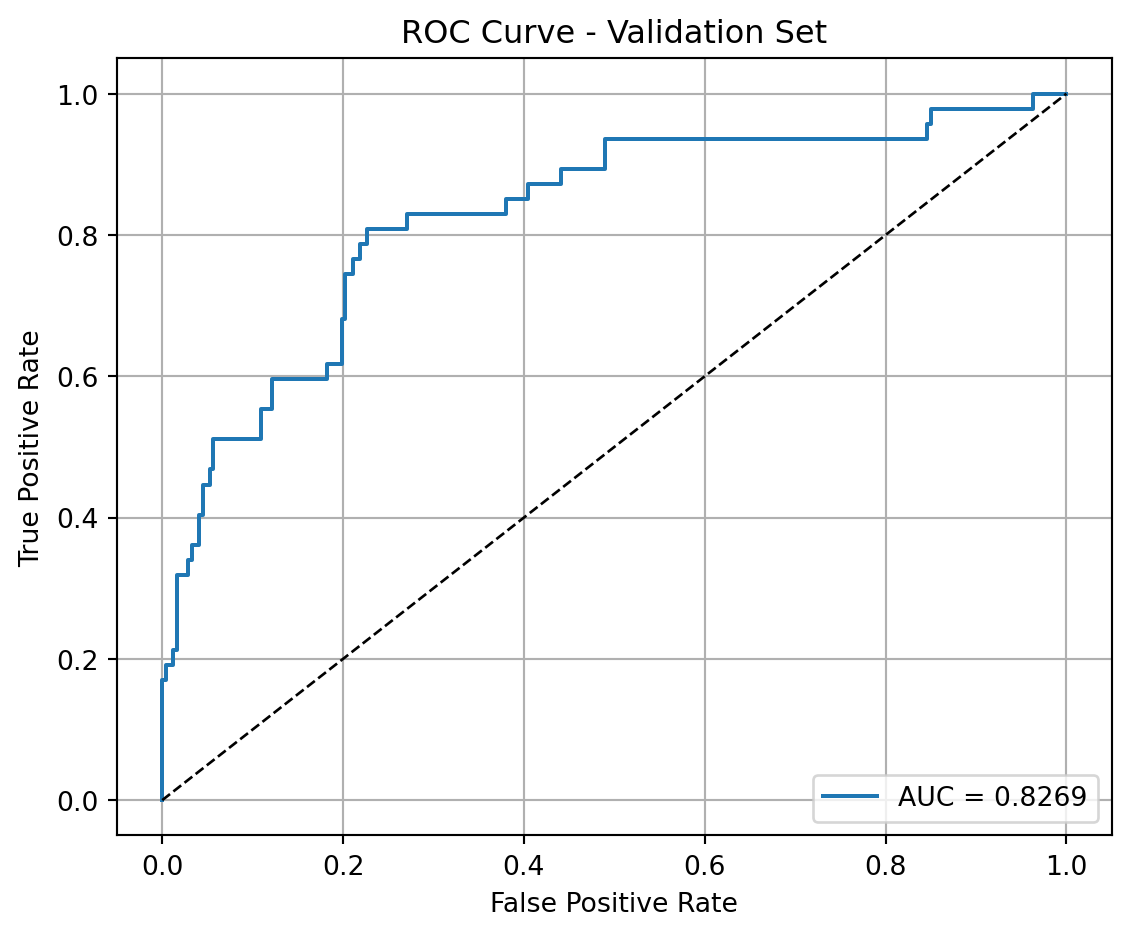

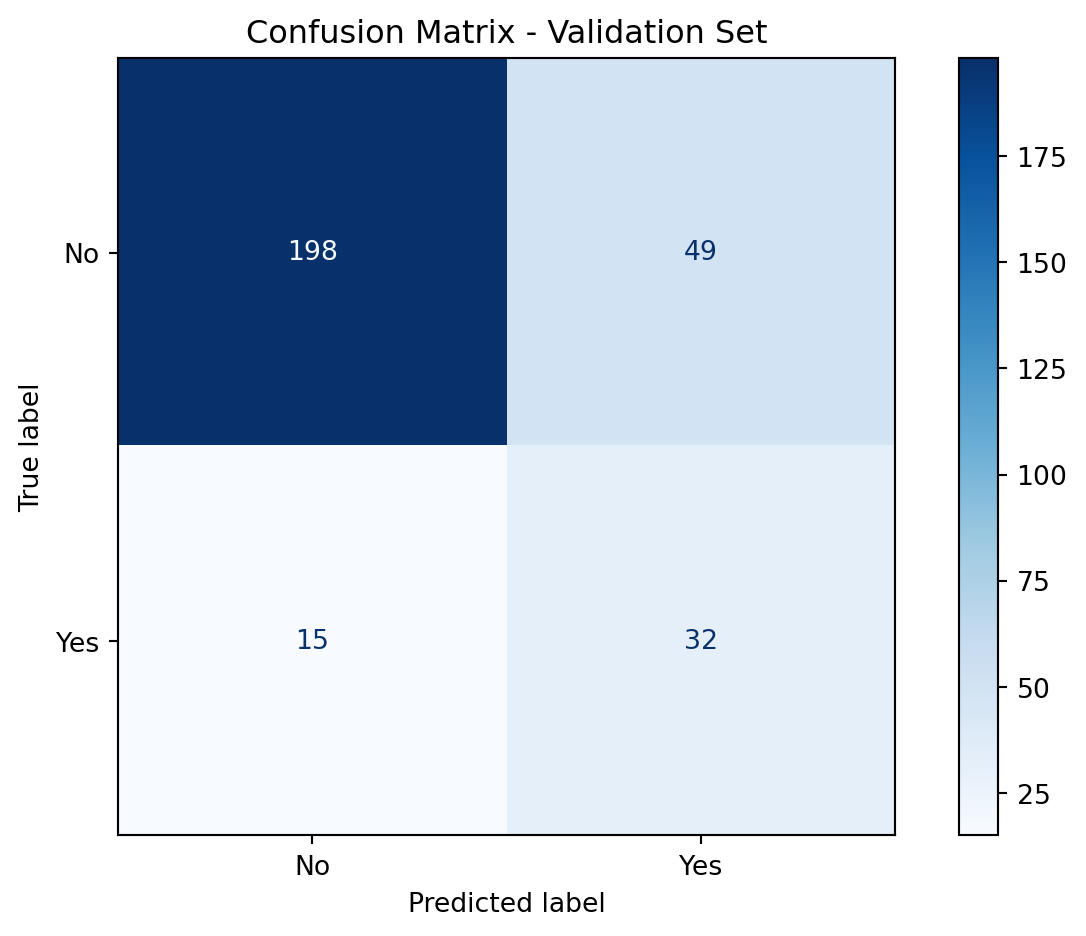

In [4]:
# Default parameters
model = LogisticRegression(solver='liblinear', max_iter=1000)

# Set up grid to tune regularization strength (C), test L1 vs L2 penalties, and possibly apply internal class weights (despite SMOTE)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

# Initialize GridSearchCV to tune model hyperparameters
grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit grid search to SMOTE-resampled training data sets
grid_search.fit(X_train_resampled, y_train_resampled)

# Get model with best hyperparameters (max 'roc_auc')
best_model = grid_search.best_estimator_

joblib.dump(preprocessing_pipeline, '../models/preprocessing_pipeline_fitted.pkl')
joblib.dump(best_model,            '../models/final_model.joblib')
print("Saved preprocessing_pipeline_fitted.pkl and final_model.joblib")

from sklearn.pipeline import Pipeline

full_pipe = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model',         best_model),
])
joblib.dump(full_pipe, '../models/final_pipeline.joblib')


# Evaluate on validation set (transformed, SMOTE not applied) 
val_proba = best_model.predict_proba(X_val_transformed)[:, 1]
val_auc = roc_auc_score((y_val == 'Yes').astype(int), val_proba)
print("Validation AUC:", round(val_auc, 4))

# Obtain predicted classes (default threshold 0.5)
val_preds = best_model.predict(X_val_transformed)

# Turn predicted classes into integers 
y_val_binary = (y_val == 'Yes').astype(int)

# Plot ROC curve 
fpr, tpr, thresholds = roc_curve(y_val_binary, val_proba)
val_auc = roc_auc_score(y_val_binary, val_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {val_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create confusion matrix and ConfusionMatrixDisplay object
cm = confusion_matrix(y_val, val_preds, labels=['No', 'Yes'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

# Display the confusion matrix 
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()


# 3. Threshold tuning
***

To maximize results, we test thresholds from 0.01 to 0.99 to find the point that best balances precision and recall. 

The optimal threshold based on F1 score is `0.79`. At this threshold: 
- F1 Score: `0.565`
- Precision: `0.632`
- Recall: `0.511`
- Accuracy: `0.874`
- AUC: `0.827`

This threshold greatly reduces false positives compared to the default (0.5), with a small trade-off in recall. 

Best Threshold (by F1): 0.79
F1 Score at Best Threshold: 0.565


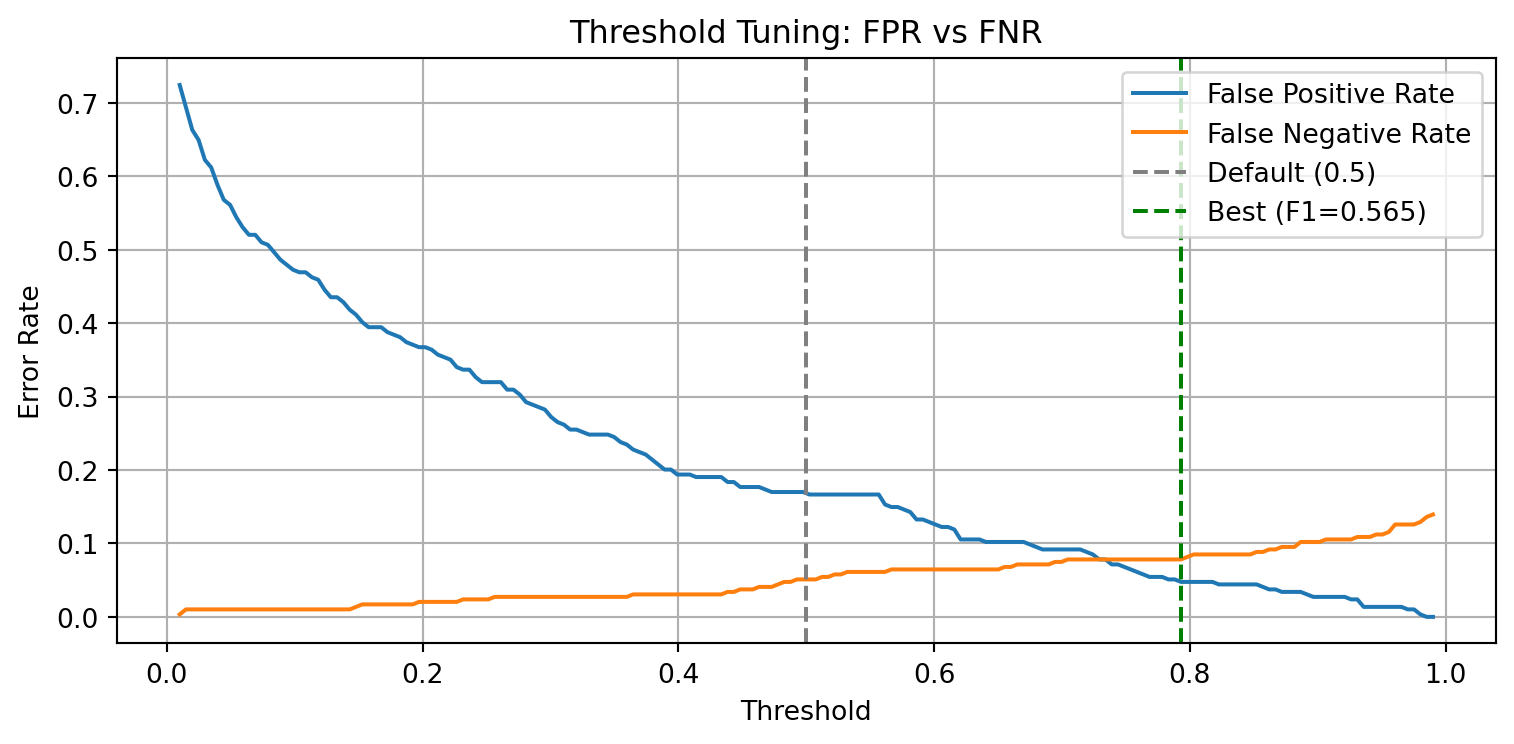

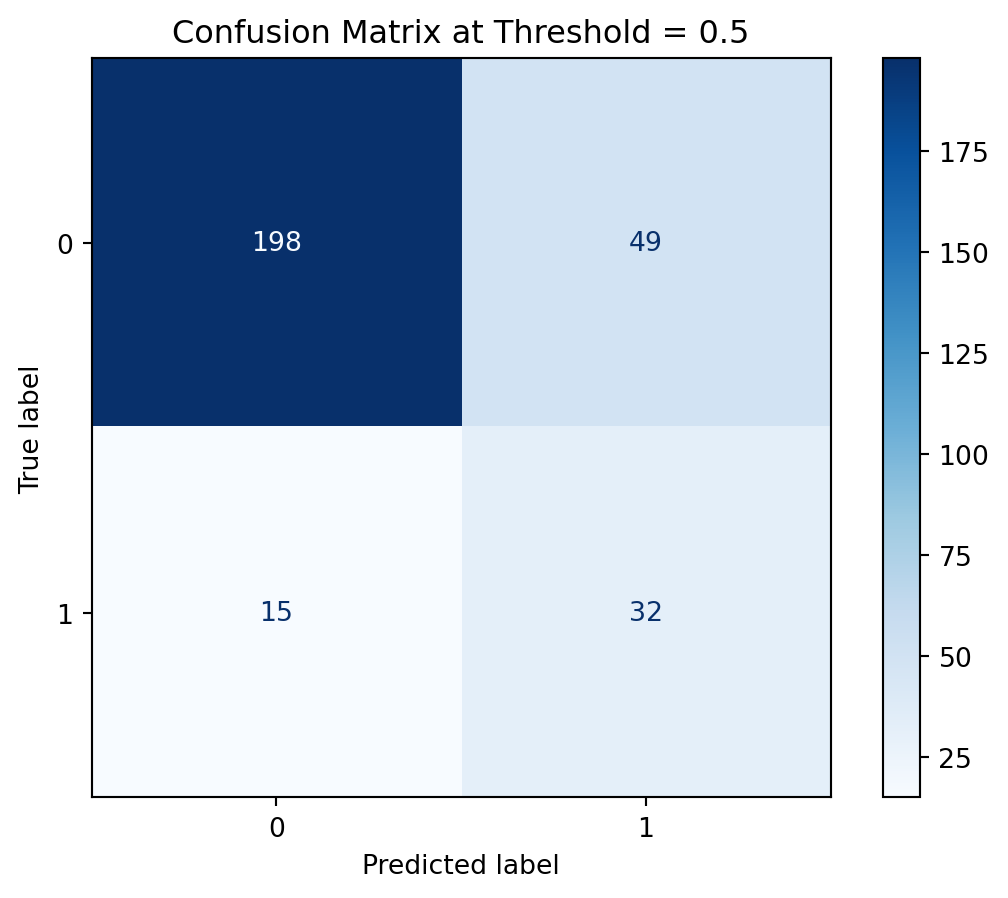

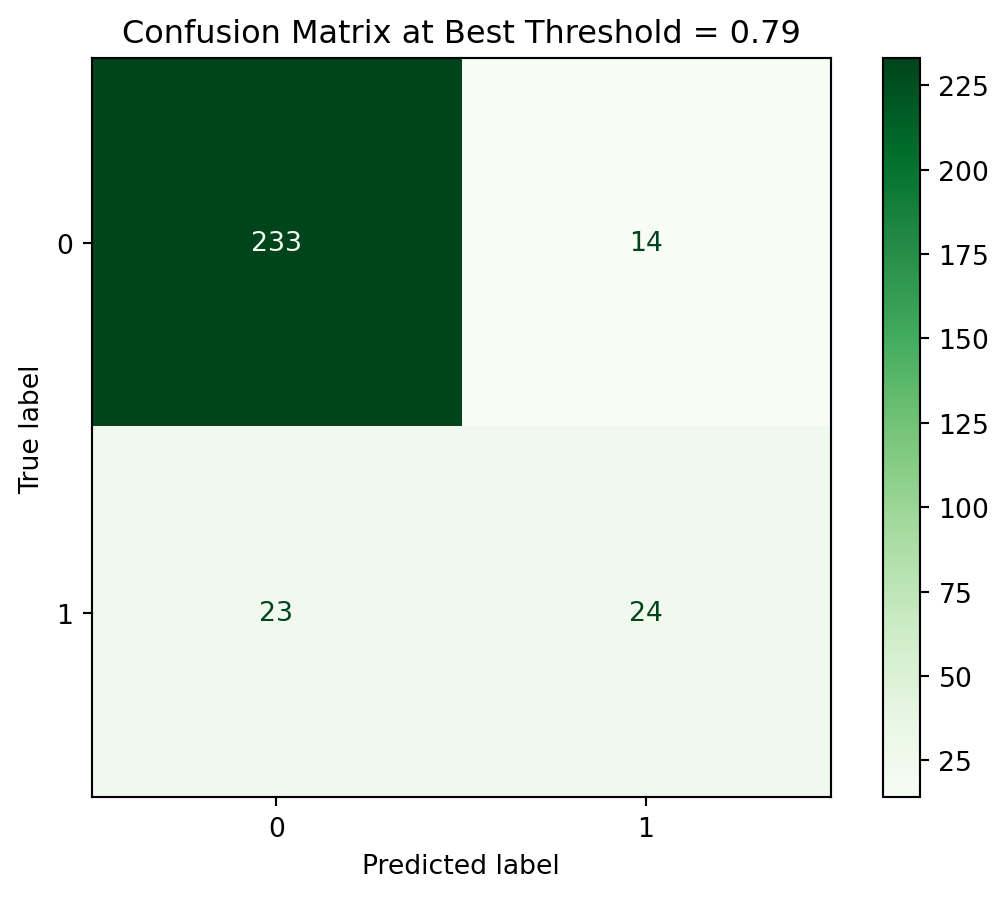


Evaluation Metrics (Best Threshold):
Precision:  0.632
Recall:     0.511
F1 Score:   0.565
Accuracy:   0.874
ROC AUC:    0.827


In [5]:
# Predict on transformed validation set
y_proba = best_model.predict_proba(X_val_transformed)[:, 1]
y_true = (y_val == 'Yes').astype(int)

# Range of thresholds to test 
thresholds = np.linspace(0.01, 0.99, 200)
fpr = []
fnr = []
f1s = []

# Obtain false positives and false negatives, and F1 scores for each threshold
for th in thresholds:
    preds = (y_proba >= th).astype(int)
    fp = np.mean((preds == 1) & (y_true == 0))
    fn = np.mean((preds == 0) & (y_true == 1))
    f1 = f1_score(y_true, preds)
    fpr.append(fp)
    fnr.append(fn)
    f1s.append(f1)

# Get index of best F1 score and assign to best_threshold
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (by F1): {best_threshold:.2f}")
print(f"F1 Score at Best Threshold: {f1s[best_idx]:.3f}")

# Plot false positives and false negatives - vertical line at threshold with best F1
plt.figure(figsize=(8, 4))
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.axvline(0.5, linestyle='--', color='gray', label='Default (0.5)')
plt.axvline(best_threshold, linestyle='--', color='green',
            label=f'Best (F1={f1s[best_idx]:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Threshold Tuning: FPR vs FNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix for threshold 0.5 (default)
default_preds = (y_proba >= 0.5).astype(int)
cm_default = confusion_matrix(y_true, default_preds)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default)
disp_default.plot(cmap='Blues')
plt.title("Confusion Matrix at Threshold = 0.5")
plt.grid(False)
plt.show()

# Confusion matrix for best threshold
tuned_preds = (y_proba >= best_threshold).astype(int)
cm_tuned = confusion_matrix(y_true, tuned_preds)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned)
disp_tuned.plot(cmap='Greens')
plt.title(f"Confusion Matrix at Best Threshold = {best_threshold:.2f}")
plt.grid(False)
plt.show()

# Metrics for best threshold
precision = precision_score(y_true, tuned_preds)
recall = recall_score(y_true, tuned_preds)
f1 = f1_score(y_true, tuned_preds)
accuracy = accuracy_score(y_true, tuned_preds)
roc_auc = roc_auc_score(y_true, y_proba)

print("\nEvaluation Metrics (Best Threshold):")
print(f"Precision:  {precision:.3f}")
print(f"Recall:     {recall:.3f}")
print(f"F1 Score:   {f1:.3f}")
print(f"Accuracy:   {accuracy:.3f}")
print(f"ROC AUC:    {roc_auc:.3f}")


# 4. Generalizability
***

The model has been tuned on SMOTE-resampled training data, and the optimal threshold has been found. Now we evaluate the model's generalization capability using the holdout test set. 

**Test Set Performance (Threshold = 0.79):**
- Accuracy: `0.861`
- Precision: `0.571`
- Recall: `0.511`
- F1 Score: `0.539`
- ROC AUC: `0.808`

**Result summary**: The metrics are strong but indicate room for improvement. The high accuracy score of 0.861 should be taken with a grain of salt - the target is highly imbalanced, so predicting No is correct more often than not. Precision and recall scores are lower than ideal - about half of the positive predictions are correct (precision), and half of the actual positives were correctly identified (recall) - but the model balances between false positives and false negatives reasonably well given the imbalanced target, as illustrated by the F1 score of 0.565. The AUC is strong, however, at 0.808, indicating that the model usually assigns higher probabilites to "Yes" values, which is the desired behavior. More complex models and perhaps more data to enrich this set could yield better results.


Evaluation on Final Test Set (Threshold = 0.79)
Accuracy:  0.861
Precision: 0.571
Recall:    0.511
F1 Score:  0.539
ROC AUC:   0.808


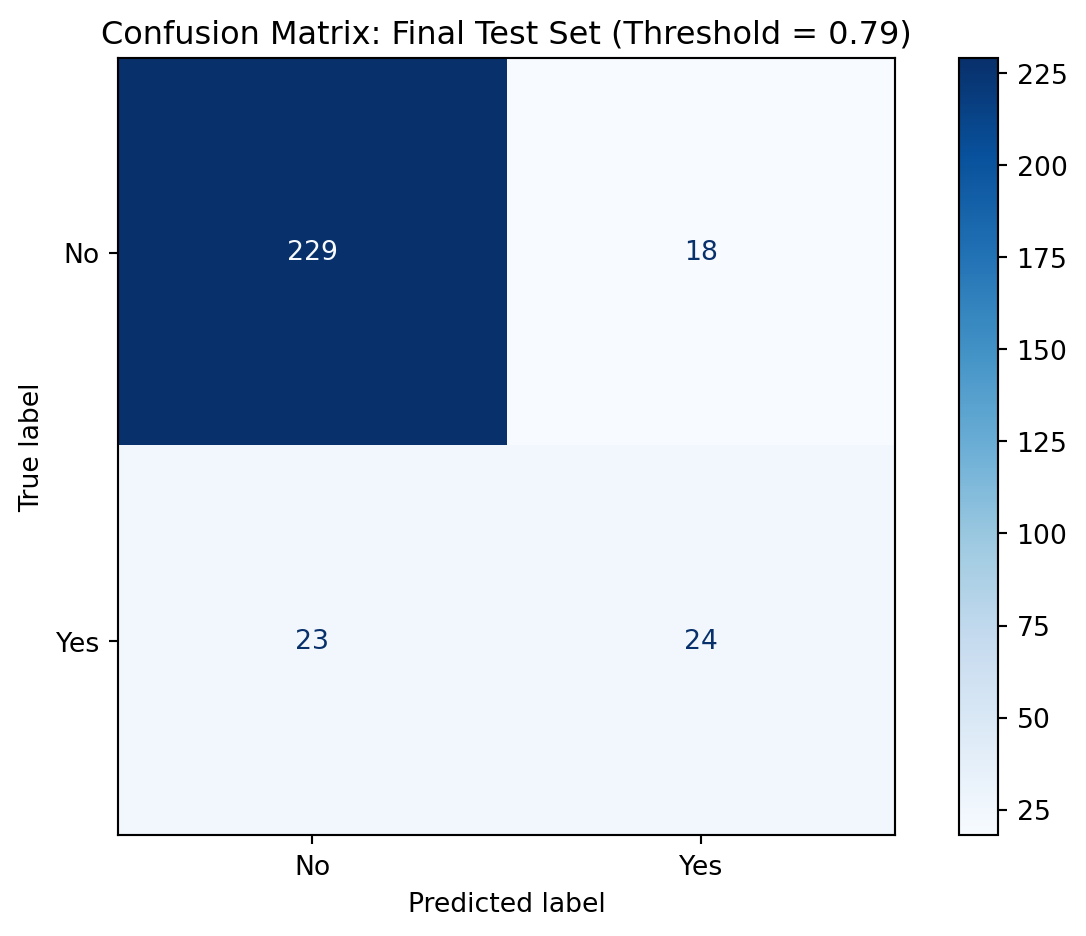

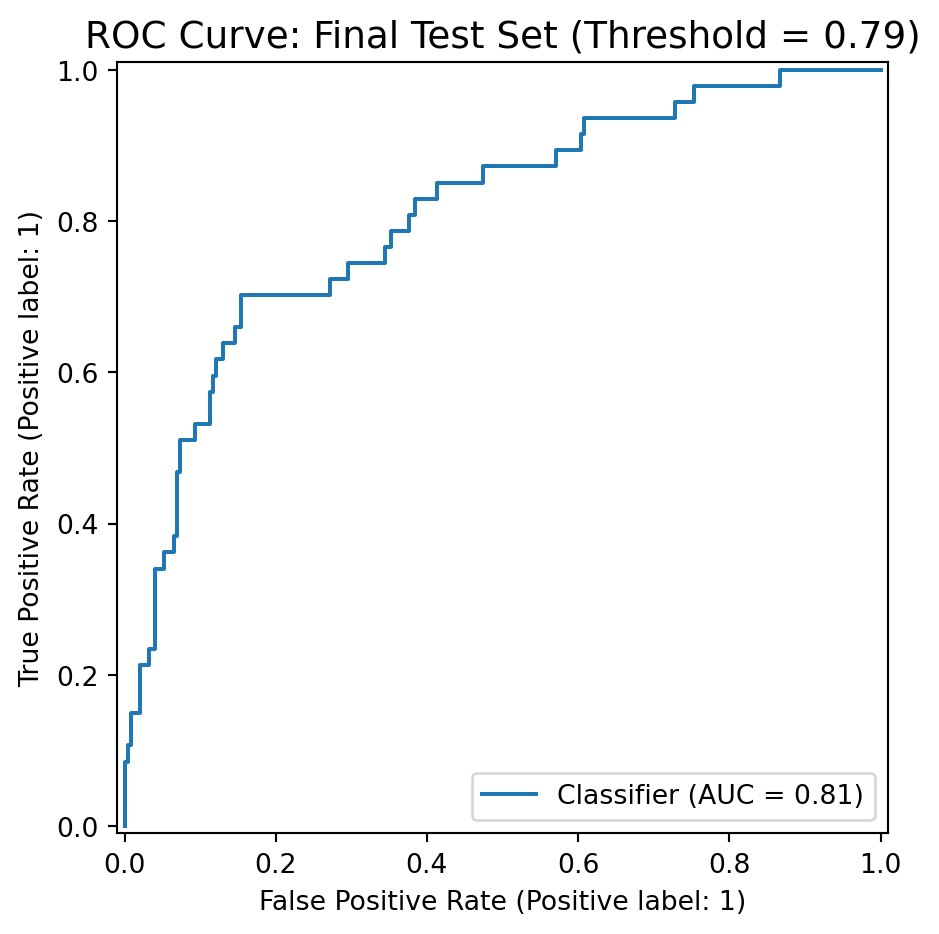

In [6]:
# Predict on untouched final test set
y_proba_test = best_model.predict_proba(X_test_transformed)[:, 1]
y_true_test = (y_final_test == 'Yes').astype(int)
y_pred_custom = (y_proba_test >= best_threshold).astype(int)

# === Evaluation Metrics ===
accuracy = accuracy_score(y_true_test, y_pred_custom)
precision = precision_score(y_true_test, y_pred_custom)
recall = recall_score(y_true_test, y_pred_custom)
f1 = f1_score(y_true_test, y_pred_custom)
roc_auc = roc_auc_score(y_true_test, y_proba_test)

print(f"\nEvaluation on Final Test Set (Threshold = {best_threshold:.2f})")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: Final Test Set (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()

# === ROC Curve ===
RocCurveDisplay.from_predictions(y_true_test, y_proba_test)
plt.title(f"ROC Curve: Final Test Set (Threshold = {best_threshold:.2f})", fontsize=14)
plt.tight_layout()
plt.show()

# **Summary and exports**
***
All preprocessing for this analysis was handled through a discrete pipeline, and the model was trained on a balanced dataset using SMOTE. 

Threshold tuning on the validation set was used to select a conservative cutoff optimized for F1 score.

The model generalizes well to unseen data, with only minimal performance drop from validation. The high precision confirms that threshold tuning reduced false positives.

The trained model, selected threshold, and test data are exported for a deeper look at the influence of individual features in the next notebook: `04_interpretation.ipynb`.

In [7]:
# === Save full trained model ===
joblib.dump(best_model, '../models/final_model.joblib')

# === Save best threshold for deployment or interpretation ===
with open('../models/best_threshold.json', 'w') as f:
    json.dump({'best_threshold': float(best_threshold)}, f)

print("Model and threshold exported successfully.")

# === Convert X_test_transformed to DataFrame with correct index and column names ===
columns = preprocessing_pipeline.named_steps['preprocessing'].get_feature_names_out()

with open('../models/x_test_columns.json', 'w') as f:
    json.dump(columns.tolist(), f)

X_test_df = pd.DataFrame(X_test_transformed, columns=columns, index=y_final_test.index)

# === Export test features and labels for SHAP ===
X_test_df.to_csv('../data/processed/X_test_transformed.csv', index=False)
y_final_test.to_csv('../data/processed/y_final_test.csv', index=False)

# Save pipeline to disk
joblib.dump(preprocessing_pipeline, '../models/fitted_pipeline.pkl')

print("Preprocessing pipeline exported successfully.")

Model and threshold exported successfully.
Preprocessing pipeline exported successfully.
